This example tests whether an approach that uses empirical characteristic functions (ECFs) can detect differences in models with different parameters. 

In [1]:
from matplotlib import pyplot as plt
import ipywidgets as ipw
from IPython.display import display
import numpy as np
import pandas as pd

from stochastic_models import model_bistable2
from stochastic_tests import Test
import stochastic_repro as sr

t_fin = 10.0
num_steps = 1000
test_kwargs = dict(t_fin=t_fin, 
                   num_steps=num_steps, 
                   sample_times=[t_fin / num_steps * i for i in range(0, num_steps + 1)], 
                   trials=[100, 500, 1000, 5000, 10000])

a1_mean = 0.9
a2_mean = 1.1

test1 = Test(model=model_bistable2({'a': ('norm', (a1_mean, 0.2))}), stochastic=False, **test_kwargs)
test2 = Test(model=model_bistable2({'a': ('norm', (a2_mean, 0.2))}), stochastic=False, **test_kwargs)
tests = [test1, test2]

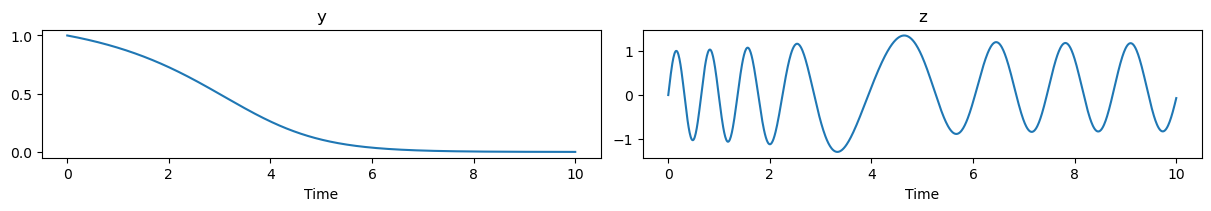

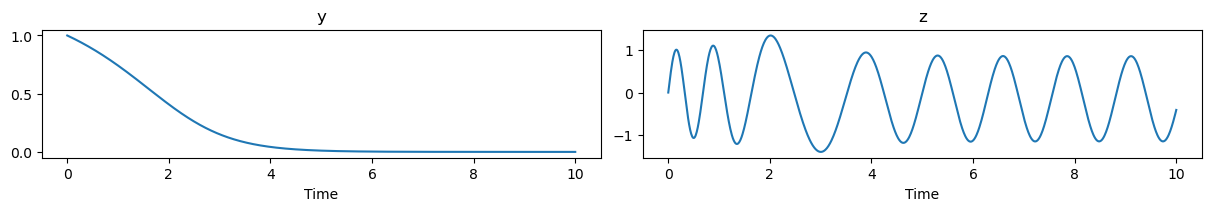

In [2]:
for test in tests:
    test.execute_deterministic()
    _ = test.plot_results_deterministic()

In [3]:
label, out = ipw.Label(), ipw.Output()
display(out)
with out:
    display(label)

for test in tests:
    test.execute_stochastic(label)
_ = out.clear_output()

Output()

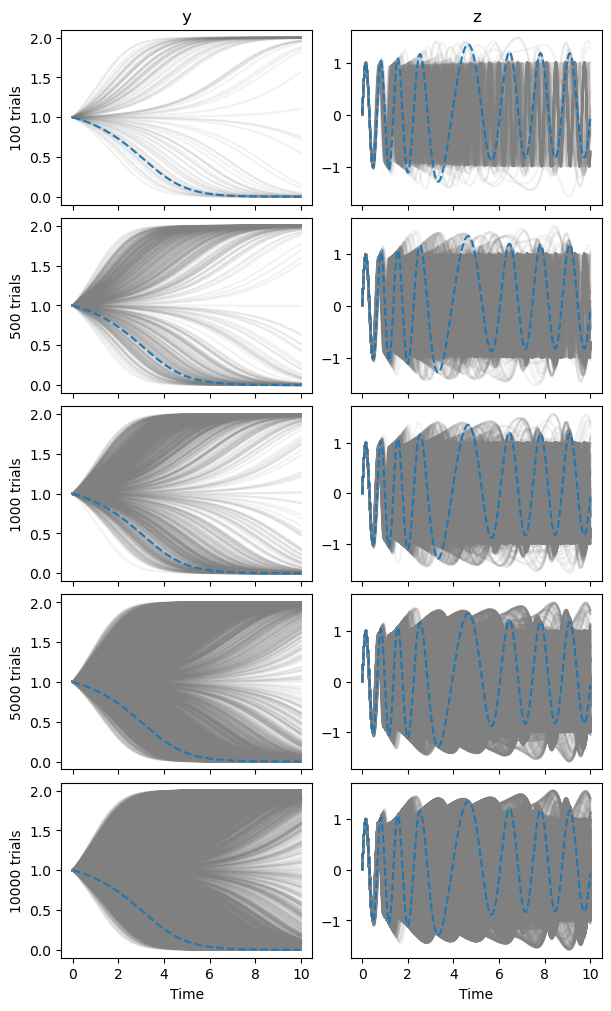

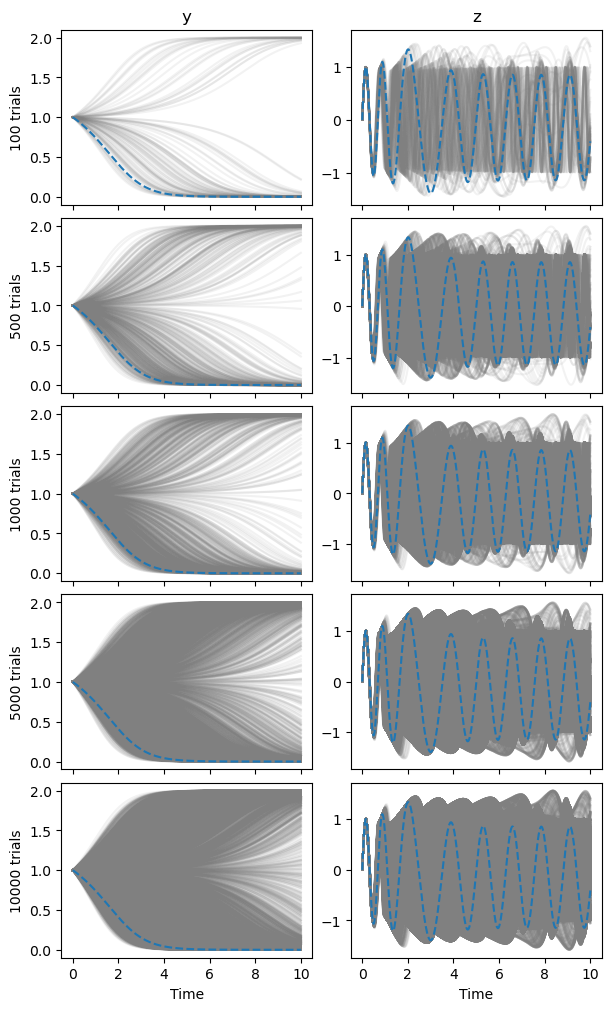

In [4]:
for test in tests:
    _ = test.plot_results_stochastic()

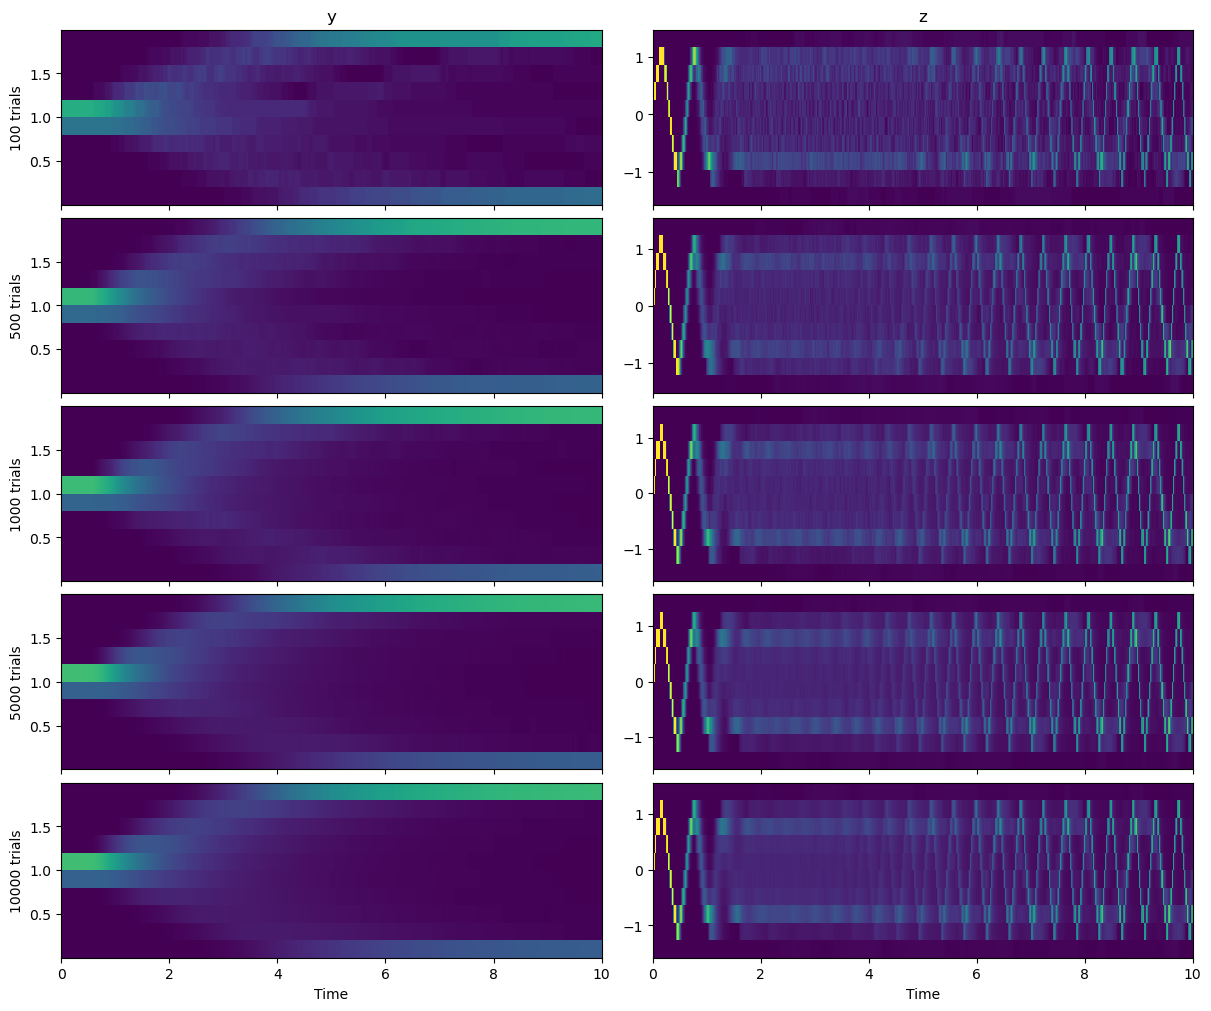

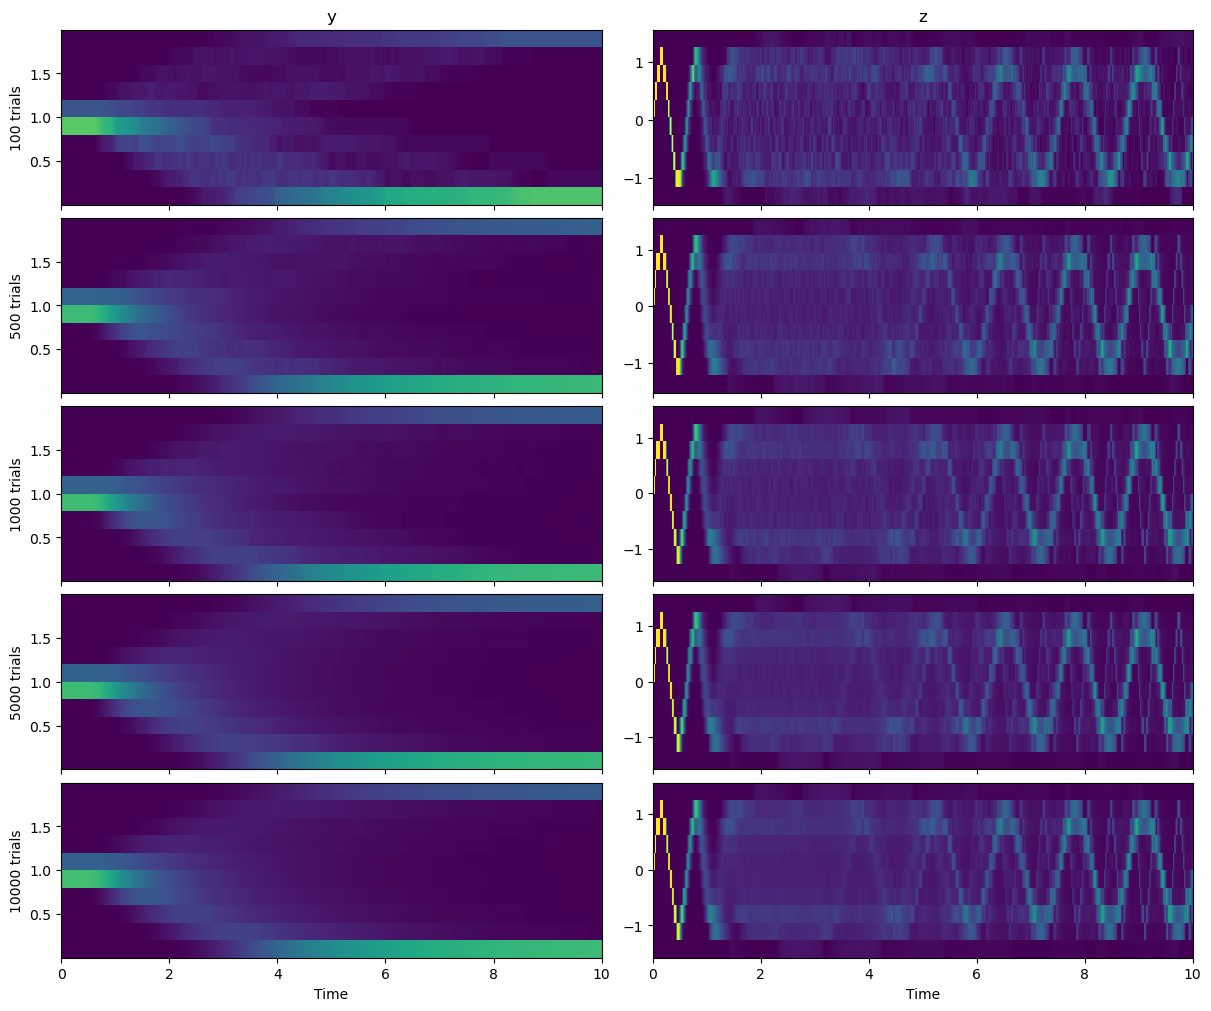

In [5]:
for test in tests:
    _ = test.plot_distributions()

/Users/timothy.sego/PycharmProjects/ssr_project_2024/code/stochastic_repro.py:992: OptimizeWarning: Covariance of the parameters could not be estimated
  return curve_fit(fit_func, data_x, data_y, **kwargs)


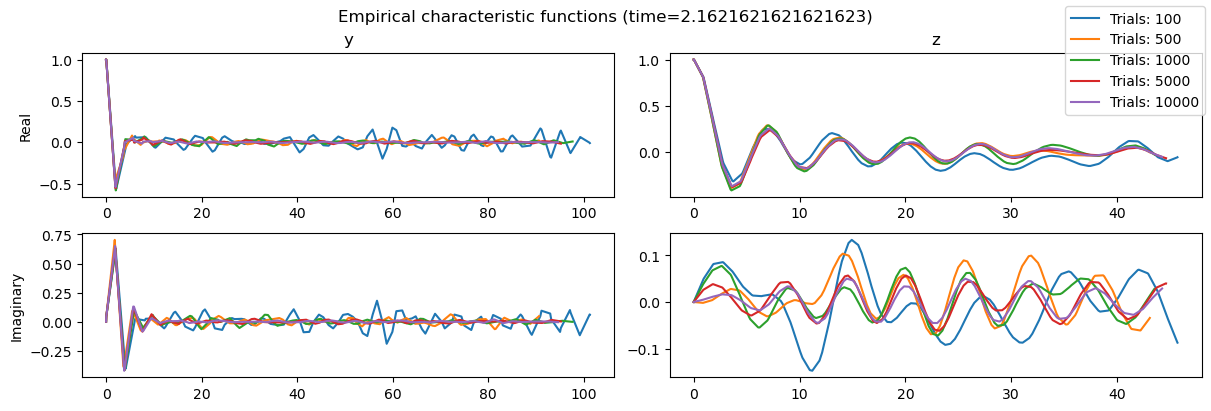

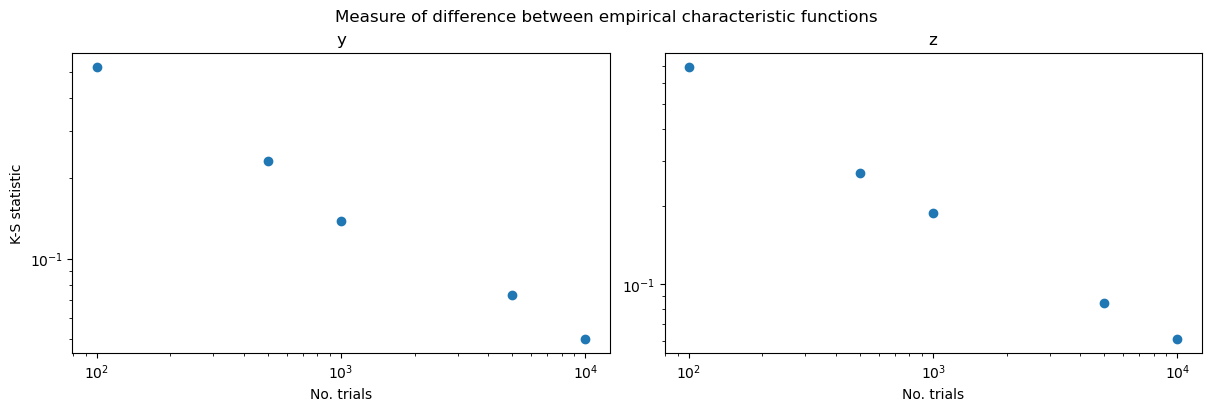

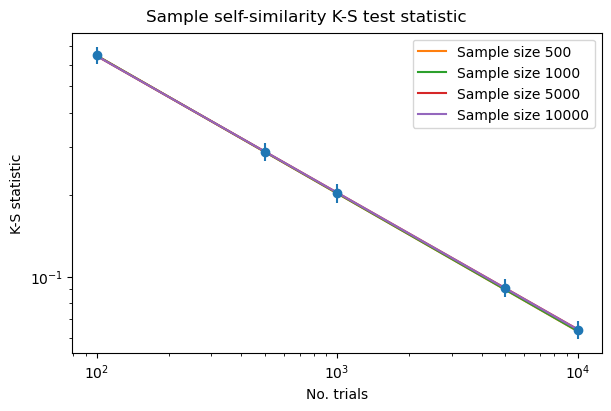

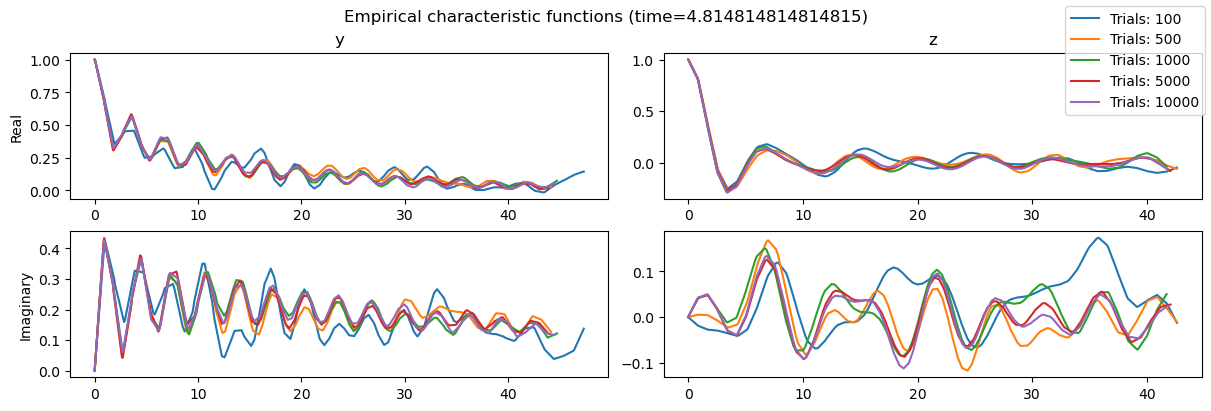

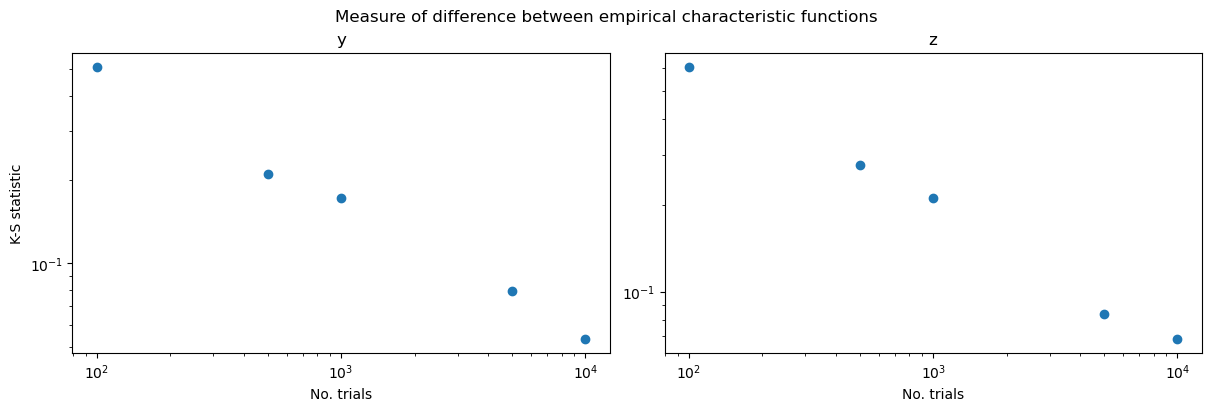

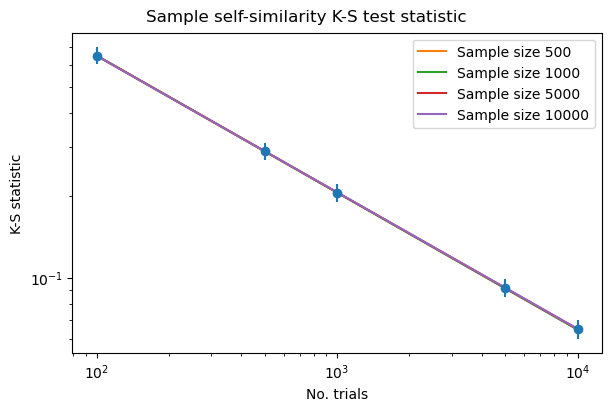

In [6]:
# Runtime: ~159 minutes (M1 max)
for test in [test1, test2]:
    test.find_ecfs()
    test.measure_ecf_diffs()
    test.plot_ecf(test.max_ks_stat_time(test.trials[-1]))
    test.plot_ecf_diffs()
    test.test_sampling(err_thresh=1E-3)
    test.generate_ecf_sampling_fits()
    _, ax = test.plot_ecf_sampling_fits(test.plot_ecf_sampling())
    _ = ax.legend()

Comparing the converged ECF of the two models, we should find that they are always quantifiably different since their models have different parameters.

Text(0.5, 0.98, 'Measure of empirical characteristic functions')

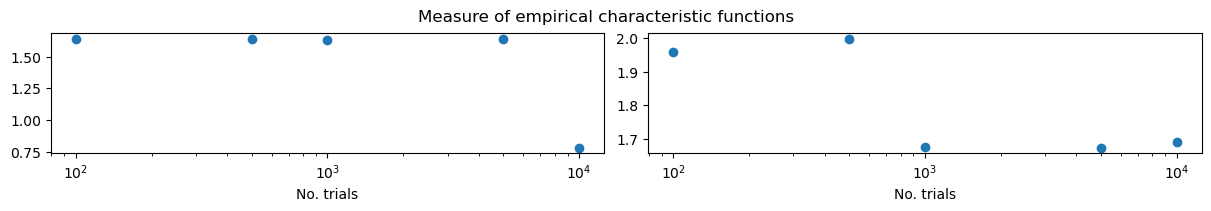

In [7]:
ecf_diff = sr.measure_ecf_diff_sets(test1.ecf, test2.ecf)

fig, ax = plt.subplots(1, len(test1.model.results_names), sharey=False, figsize=(12.0, 2.0), layout='compressed')
for i, name in enumerate(test1.model.results_names):
    ax[i].scatter(test1.trials, [max([el[name] for el in ecf_diff[trial]]) for trial in test1.trials])
    ax[i].set_xlabel('No. trials')
    ax[i].set_xscale('log')
fig.suptitle('Measure of empirical characteristic functions')

Testing for how well the method can detect differences in model parameters. 

Output()

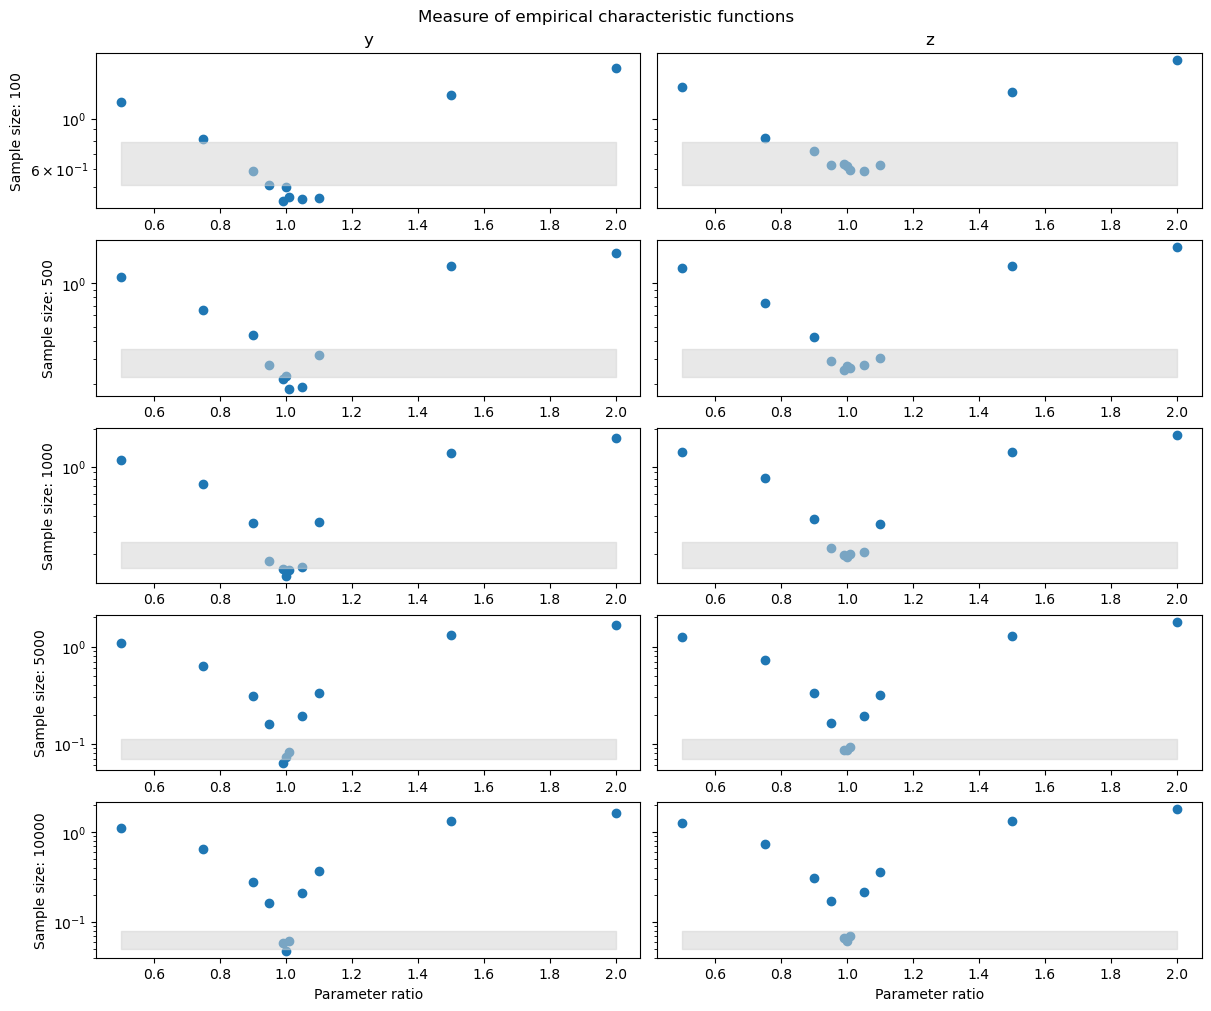

In [15]:
a_fact = [0.5, 0.75, 0.9, 0.95, 0.99, 1.0, 1.01, 1.05, 1.1, 1.5, 2.0]
a_comp = list()
test_test_kwargs = test_kwargs.copy()
test_test_kwargs['trials'] = [int(t / 2) for t in test_kwargs['trials']]

label, out = ipw.Label(), ipw.Output()
display(out)
with out:
    display(label)

# Make half-size tests
test1_sims_hs = {}
ecf_eval_info = {}
for trials in test1.trials:
    ht = int(trials / 2)
    simset = sr.SimSet(model=test1.model, num_trials=ht, stochastic=False, num_steps=test_kwargs['num_steps'], t_fin=test_kwargs['t_fin'])
    simset.results = {k: v[:ht, :] for k, v in test1.sims_s[trials].results.items()}
    simset.results_time = test1.sims_s[trials].results_time
    test1_sims_hs[ht] = simset
    ecf_eval_info[ht] = test1.ecf_eval_info[trials]
ecf1 = sr.generate_ecfs(test1_sims_hs, test1.sample_times, test1.model.results_names, test_test_kwargs['trials'], ecf_eval_info)

for af in a_fact:
    label.value = f'Factor: {af}...'

    atest_mean = a1_mean * af
    test = Test(model=model_bistable2({'a': ('norm', (atest_mean, 0.2))}), stochastic=False, **test_test_kwargs)
    test.execute_stochastic()
    ecf2 = sr.generate_ecfs(test.sims_s, test1.sample_times, test1.model.results_names, test_test_kwargs['trials'], ecf_eval_info)
    a_comp.append(sr.measure_ecf_diff_sets(ecf1, ecf2))

out.clear_output()

fig, ax = plt.subplots(len(test1.trials), len(test1.model.results_names), sharey='row', figsize=(12.0, 2.0 * len(test1.trials)), layout='compressed')
for i, trial in enumerate(test1.trials):
    for j, name in enumerate(test1.model.results_names):
        ax[i][j].scatter(a_fact, [max([el[name] for el in diff[int(trial / 2)]]) for diff in a_comp])
        
        avg = np.average(test1.ks_stats_sampling[trial])
        err = np.std(test1.ks_stats_sampling[trial]) * 3
        ax[i][j].fill_between(a_fact, avg - err, avg + err, color='lightgray', alpha=0.5)
        ax[i][j].set_yscale('log')

for i, name in enumerate(test1.model.results_names):
    ax[0][i].set_title(name)
    ax[-1][i].set_xlabel('Parameter ratio')
for i, trial in enumerate(test1.trials):
    ax[i][0].set_ylabel(f'Sample size: {trial}')
_ = fig.suptitle('Measure of empirical characteristic functions')

In [20]:
summary_entries = ['Average', 'St. dev.']
df_summary = pd.DataFrame(index=test_kwargs['trials'], columns=summary_entries)
eval_entries = ['Sample size', 'Scaling factor', 'Error', 'Standardized error', 'Acceptance p-value']
data_eval = []

for sample_size in test_test_kwargs['trials']:
    avg = np.average(test1.ks_stats_sampling[sample_size * 2])
    std = np.std(test1.ks_stats_sampling[sample_size * 2])
    df_summary.loc[sample_size * 2, 'Average'] = avg
    df_summary.loc[sample_size * 2, 'St. dev.'] = std

    err = [max([max(d.values()) for d in diff[sample_size]]) for diff in a_comp]
    q2 = (sample_size + 1) / sample_size * np.var(test1.ks_stats_sampling[sample_size * 2], ddof=1)
    lam2 = [(e - avg) * (e - avg) / q2 for e in err]
    pr = [np.floor((sample_size + 1) / sample_size * ((sample_size - 1) / l2 + 1)) / (sample_size + 1) for l2 in lam2]
    for i in range(len(err)):
        if pr[i] > 1.0 or err[i] < avg:
            pr[i] = 1.0

    for i, bf in enumerate(a_fact):
        data_eval.append((sample_size * 2, bf, err[i], (err[i] - avg) / std, min(1, pr[i])))

display(df_summary)
mi_eval = pd.MultiIndex.from_frame(pd.DataFrame(data_eval, columns=eval_entries))
df_eval = mi_eval.to_frame()
display(df_eval)

,Average,St. dev.
100,0.648374,0.046614
500,0.287486,0.0215
1000,0.20278,0.015495
5000,0.091461,0.007112
10000,0.064132,0.004659


Sample size  \
Sample size Scaling factor Error    Standardized error Acceptance p-value                
100         0.50           1.371745  15.518265         0.019608                    100   
            0.75           0.824983  3.788735          0.078431                    100   
            0.90           0.720178  1.540386          0.431373                    100   
            0.95           0.620997 -0.587306          1.000000                    100   
            0.99           0.627603 -0.445599          1.000000                    100   
            1.00           0.620476 -0.598476          1.000000                    100   
            1.01           0.590363 -1.244494          1.000000                    100   
            1.05           0.584045 -1.380031          1.000000                    100   
            1.10           0.623404 -0.535662          1.000000                    100   
            1.50           1.308619  14.164044         0.019608                    100   
            2.00           1.813092  24.986340         0.019608                    100   
500         0.50           1.277393  46.041942         0.003984                    500   
            0.75           0.734180  20.776370         0.003984                    500   
            0.90           0.438119  7.006169          0.023904                    500   
            0.95           0.287738  0.011721          1.000000                    500   
            0.99           0.250125 -1.737713          1.000000                    500   
            1.00           0.269396 -0.841409          1.000000                    500   
            1.01           0.261021 -1.230901          1.000000                    500   
            1.05           0.272162 -0.712748          1.000000                    500   
            1.10           0.320133  1.518456          0.438247                    500   
            1.50           1.321199  48.079448         0.003984                    500   
            2.00           1.772604  69.074906         0.003984                    500   
1000        0.50           1.298481  70.715424         0.001996                   1000   
            0.75           0.808092  39.066213         0.001996                   1000   
            0.90           0.380788  11.488437         0.007984                   1000   
            0.95           0.225664  1.476877          0.461078                   1000   
            0.99           0.199083 -0.238612          1.000000                   1000   
            1.00           0.190387 -0.799829          1.000000                   1000   
            1.01           0.200923 -0.119880          1.000000                   1000   
            1.05           0.209555  0.437252          1.000000                   1000   
            1.10           0.361937  10.271822         0.009980                   1000   
            1.50           1.302718  70.988840         0.001996                   1000   
            2.00           1.790290  102.456237        0.001996                   1000   
5000        0.50           1.263727  164.825735        0.000400                   5000   
            0.75           0.729842  89.759135         0.000400                   5000   
            0.90           0.330897  33.665807         0.001200                   5000   
            0.95           0.165615  10.426416         0.009596                   5000   
            0.99           0.086317 -0.723210          1.000000                   5000   
            1.00           0.086434 -0.706845          1.000000                   5000   
            1.01           0.093471  0.282626          1.000000                   5000   
            1.05           0.193742  14.381140         0.005198                   5000   
            1.10           0.331738  33.784044         0.001200                   5000   
            1.50           1.304702  170.587023        0.000400                   5000   
            2.00         